# _qib_ WMI Backend Integration

In this example we test qib's backend module, and its integration capability with the quantum devices provided by the Walter-Meissner Institute.

In [1]:
# Set-up Python package dependencies
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Set-up Python module dependencies
import qib
import matplotlib.pyplot as plt
import math

In [2]:
# Set-up backend API access token
access_token = input("(WMI) Enter API access token: ")

## **WMI Qiskit Simulator Backend (QSim)**

Define circuits for all 4 Bell states

In [3]:
def wmi_qs_bell_circuits() -> qib.Circuit:
    # Qubits
    field = qib.field.Field(
        qib.field.ParticleType.QUBIT, qib.lattice.IntegerLattice((3,)))
    q0 = qib.field.Qubit(field, 0)
    q1 = qib.field.Qubit(field, 1)

    # Bell State Φ+ Circuit
    circuit_phi_plus = qib.Circuit([
        qib.HadamardGate(q0),
        qib.HadamardGate(q1),
        qib.ControlledGate(qib.PauliZGate(q1), 1).set_control(q0),
        qib.HadamardGate(q1),
        qib.MeasureInstruction([q0, q1])
    ])
    
    # Bell State Φ- Circuit
    circuit_phi_minus = qib.Circuit([
        qib.PauliXGate(q0),
        qib.HadamardGate(q0),
        qib.HadamardGate(q1),
        qib.ControlledGate(qib.PauliZGate(q1), 1).set_control(q0),
        qib.HadamardGate(q1),
        qib.MeasureInstruction([q0, q1])
    ])
    
    # Bell State Ψ+ Circuit
    circuit_psi_plus = qib.Circuit([
        qib.HadamardGate(q0),
        qib.PauliXGate(q1),
        qib.HadamardGate(q1),
        qib.ControlledGate(qib.PauliZGate(q1), 1).set_control(q0),
        qib.HadamardGate(q1),
        qib.MeasureInstruction([q0, q1])
    ])
    
    # Bell State Ψ- Circuit
    circuit_psi_minus = qib.Circuit([
        qib.HadamardGate(q0),
        qib.PauliXGate(q1),
        qib.RzGate(math.pi, q0),
        qib.RzGate(math.pi, q1),
        qib.HadamardGate(q1),
        qib.ControlledGate(qib.PauliZGate(q1), 1).set_control(q0),
        qib.HadamardGate(q1),
        qib.MeasureInstruction([q0, q1])
    ])
    
    return [circuit_phi_plus, circuit_phi_minus, circuit_psi_plus, circuit_psi_minus]

Set-up and execute the experiment on the given backend

In [4]:
def wmi_qs_experiment(circuit: qib.Circuit, access_token: str) -> qib.backend.ExperimentResults:
    # Processor & Experiment
    processor = qib.backend.wmi.WMIQSimProcessor(access_token=access_token)
    options = qib.backend.wmi.WMIOptions(shots=4096)
    experiment = processor.submit_experiment(
        name = 'qib-integration-test-qs',
        circ = circuit,
        options = options)
    results = experiment.results()
    return results

Plot the experiment results (i.e. measured counts) histogram

In [5]:
def wmi_qs_plot_states(results_counts: list[dict]) -> None:
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))  # Create a 2x2 grid of subplots

    for idx, counts in enumerate(results_counts):
        ax = axes.flat[idx]  # Access each subplot in the grid

        # Create the bar plot for each subplot
        ax.bar(counts.keys(), counts.values(), color='dodgerblue')

        # Add count value labels on top of the bars
        max_value = max(counts.values())
        for j, v in enumerate(counts.values()):
            y_pos = min(max_value, v) - 40
            ax.text(j, y_pos, str(v), ha='center', va='top', fontsize=12, color='darkblue')

        # Set subplot titles with desired labels
        positions = ['B. State Φ+', 'B. State Φ-', 'B. State Ψ+', 'B. State Ψ-']
        ax.set_title(positions[idx])

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

**Execution Flow**

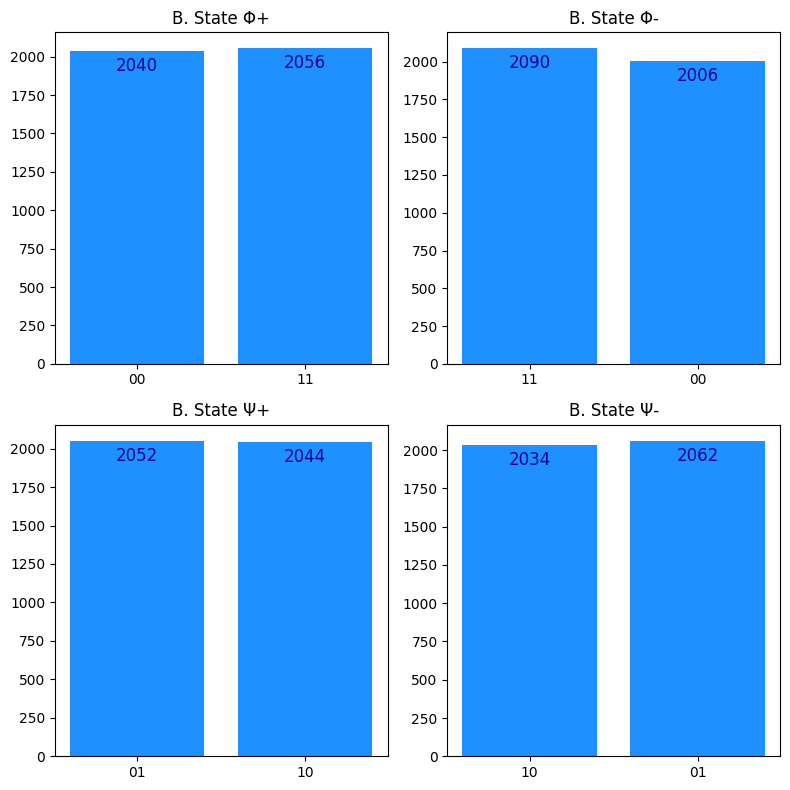

In [6]:
# Initialize the circuits and run the experiment
bell_circuits = wmi_qs_bell_circuits()
results_counts: list[dict] = []
for circuit in bell_circuits:
    results = wmi_qs_experiment(circuit, access_token)
    results_counts.append(results.get_counts(binary=True))

# Plot experiment results
wmi_qs_plot_states(results_counts)

## **WMI Quantum Computer Backend (QC)**

In [7]:
def wmi_qc_circuit():
    # Qubits
    field = qib.field.Field(
        qib.field.ParticleType.QUBIT, qib.lattice.IntegerLattice((3,)))
    q0 = qib.field.Qubit(field, 0)

    # Circuit
    circuit = qib.Circuit([
        qib.SxGate(q0),
        qib.MeasureInstruction([q0])
    ])
    
    return circuit

In [8]:
def wmi_qc_experiment(circuit: qib.Circuit, access_token: str) -> qib.backend.ExperimentResults:
    # Processor & Experiment
    processor = qib.backend.wmi.WMIQCProcessor(access_token=access_token)
    experiment = processor.submit_experiment(
        name = 'qib-integration-test-qc',
        circ = circuit)
    results = experiment.results()
    return results

In [9]:
def wmi_qc_plot(counts: dict) -> None:
    fig = plt.figure(figsize=(4, 4))
    plt.bar(counts.keys(), counts.values(), color='dodgerblue')

    # Add count value labels on top of the bars
    max_value = max(counts.values())
    for i, v in enumerate(counts.values()):
        y_pos = min(max_value, v) - 40
        plt.text(i, y_pos, str(v), ha='center', va='top', fontsize=12, color='darkblue')

    plt.show()

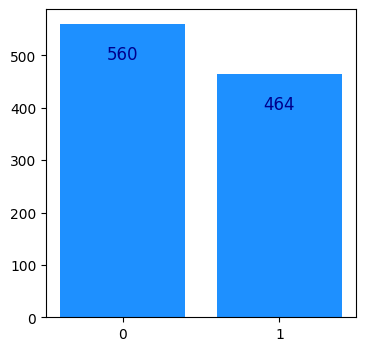

In [10]:
# Initialize the circuits and run the experiment
circuit = wmi_qc_circuit()
results = wmi_qc_experiment(circuit, access_token).get_counts(binary=True)

# Plot experiment results
wmi_qc_plot(results)